# 

# ORACLE MADC Intership Program Generic 2024
## ML-Tweets Classification

### ESSALHI SARA -- Software and System Intelligent Engineer
#### Faculty of Science and Technology Tangier





# 

# Importing necessary libraries and setting up the environment

In [17]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Load the English stopwords
stop_words = set(stopwords.words('english'))

%matplotlib inline

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis (EDA)

####  Loading dataset files into pandas dataframes

In [55]:
sample_submission = pd.read_csv('/kaggle/input/deeptweets/sample_submission.csv')
train_data = pd.read_csv('/kaggle/input/deeptweets/training.csv')
test_data = pd.read_csv('/kaggle/input/deeptweets/test.csv')

In [19]:
train_data.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


#### Dropping the 'TweetId' column from the training dataset

In [56]:
train_data=train_data.drop(columns = ['TweetId'])

In [21]:
train_data.describe()

,Label,TweetText
count,6525,6525
unique,2,6508
top,Sports,'Coaches: Check out the latest content from th...
freq,3325,3


In [22]:
train_data.groupby(['Label']).describe()

TweetText                                                            \
             count unique                                                top   
Label                                                                          
Politics      3200   3191  'RT @HouseofCommons: Prime Minister\u2019s Que...   
Sports        3325   3317  'Coaches: Check out the latest content from th...   

               
         freq  
Label          
Politics    3  
Sports      3

In [23]:
train_data["length"] = train_data["TweetText"].apply(len)
train_data.head()

,Label,TweetText,length
0,Politics,'#SecKerry: The value of the @StateDept and @U...,125
1,Politics,'@rraina1481 I fear so',23
2,Sports,'Watch video highlights of the #wwc13 final be...,102
3,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,121
4,Sports,'@cricketfox Always a good thing. Thanks for t...,62


#### Visualizing the distribution of text length in tweets

- The distribution of text length in tweets appears to be right-skewed, with most tweets having a length between 0 and 50 characters.
- There is a peak around the 140-character mark, which is the character limit for tweets on Twitter.
Some tweets have lengths extending beyond 150 characters, with a long tail indicating a few tweets with very high character counts.

/tmp/ipykernel_191/3335106521.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data["length"] , bins = 50)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='length', ylabel='Density'>

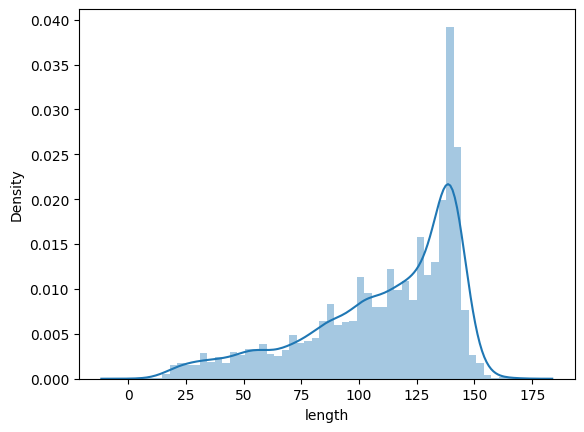

In [24]:
sns.distplot(train_data["length"] , bins = 50)

In [25]:
train_data["length"].describe()

count    6525.000000
mean      110.346820
std        32.234194
min         5.000000
25%        91.000000
50%       119.000000
75%       138.000000
max       167.000000
Name: length, dtype: float64

#### Visualizing the distribution of text length in tweets by label

- The histograms show the distribution of text length in tweets for the 'Politics' and 'Sports' categories.
- Both categories have a similar distribution pattern, with most tweets having lengths between 0 and 140 characters.
- There are peaks around the 140-character mark, indicating the presence of tweets near the character limit.
- Some tweets have lengths extending beyond 140 characters, with a long tail indicating a few tweets with very high character counts.

array([<Axes: title={'center': 'Politics'}>,
       <Axes: title={'center': 'Sports'}>], dtype=object)

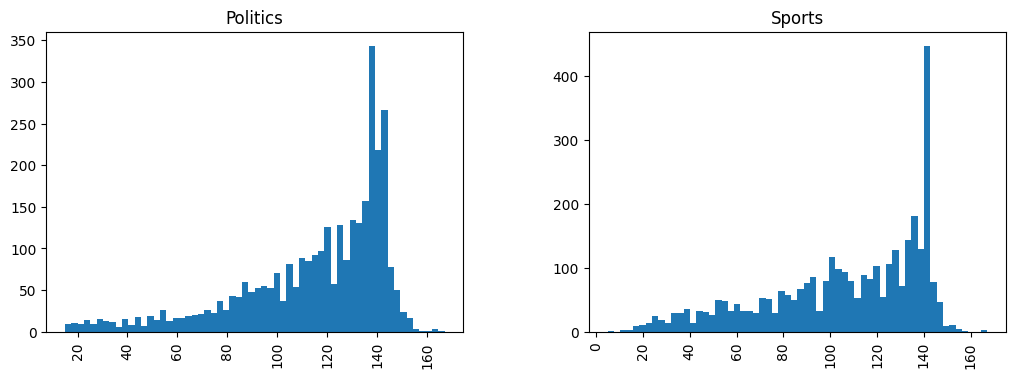

In [26]:
train_data.hist(column="length" , by="Label", bins = 60 ,figsize= (12,4))

#### Visualizing the distribution of hashtags, mentions, URLs, and stopwords counts in tweets

- The histograms show the distribution of text features (hashtags count, mentions count, URLs count, and stopwords count) in tweets.
- For hashtags count and mentions count, most tweets have a small number of hashtags or mentions, with a few tweets having a higher count.
- The distribution of URLs count indicates that most tweets do not contain URLs, while some tweets include one or more URLs.
- In the distribution of stopwords count, most tweets have a small number of stopwords, with only a few tweets containing a higher count.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

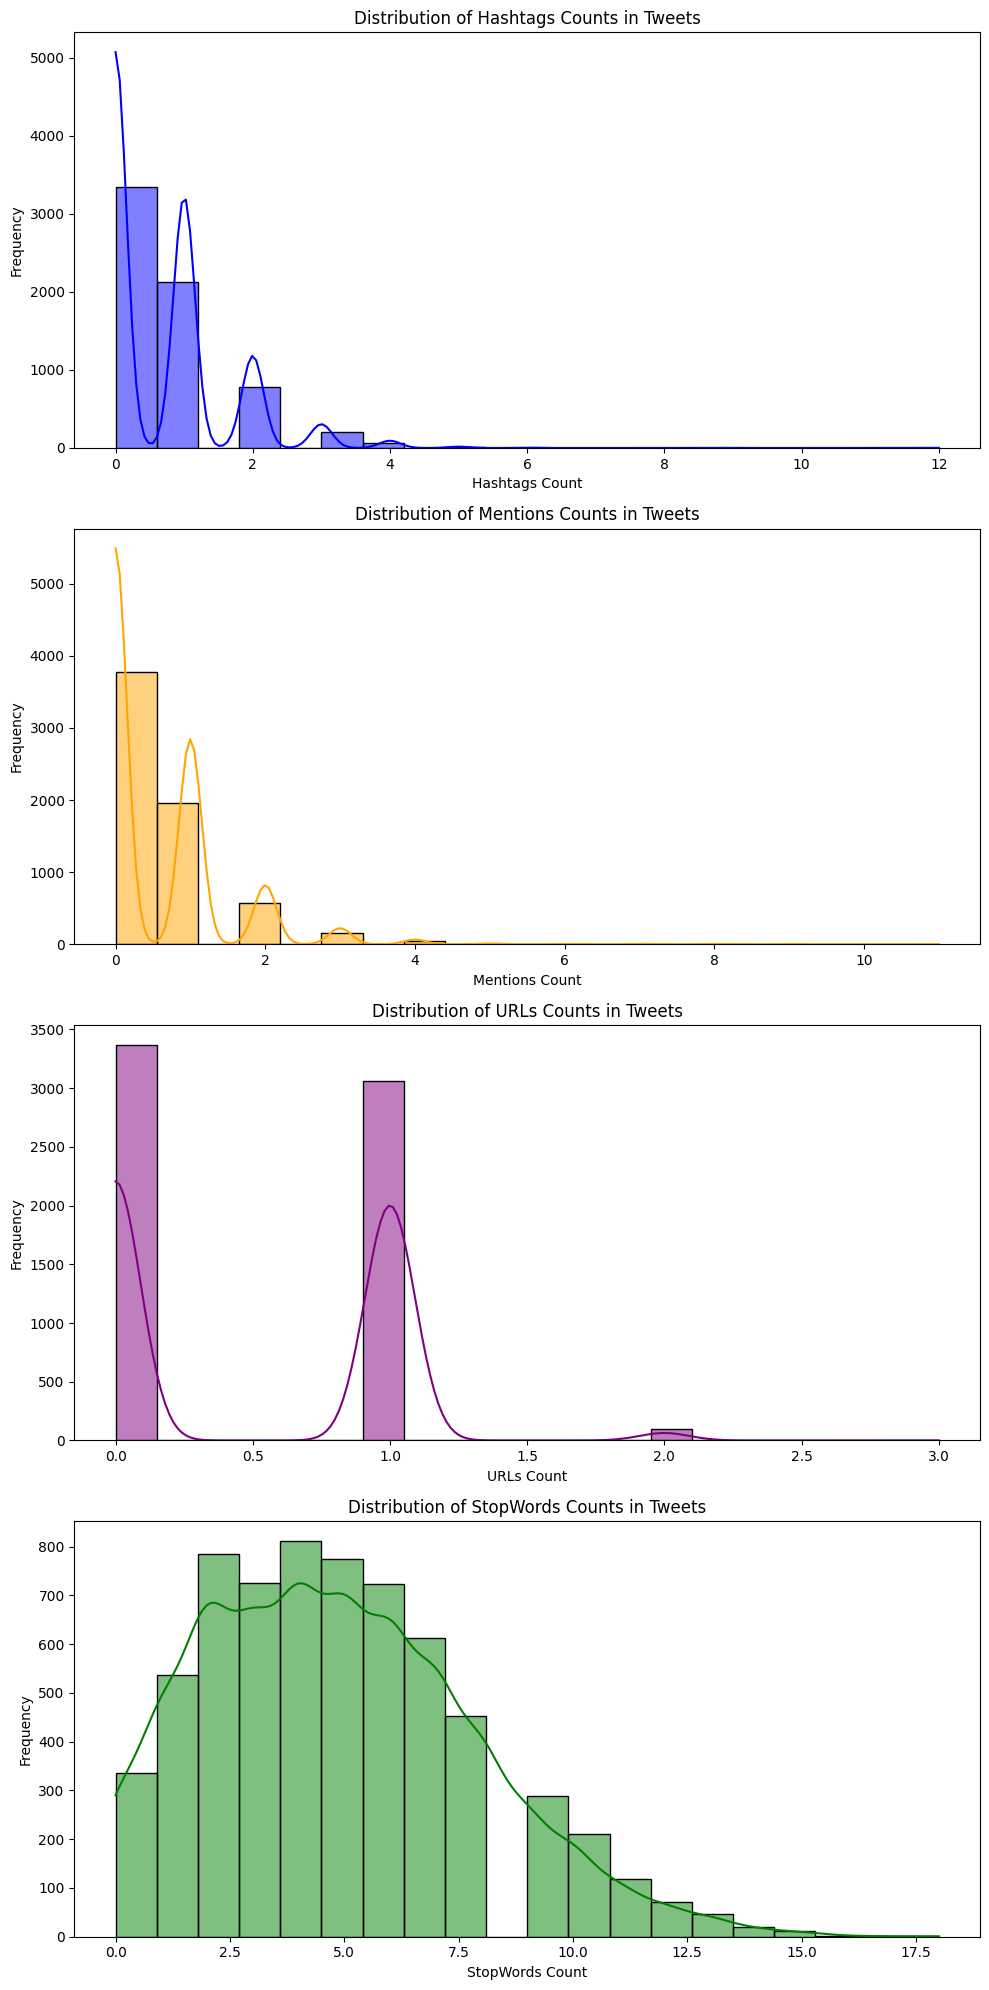

In [27]:
# Function to count hashtags in a tweet
def count_hashtags(text):
    hashtags_count = len(re.findall(r'#\w+', text))
    return hashtags_count

# Function to count mentions in a tweet
def count_mentions(text):
    mentions_count = len(re.findall(r'@\w+', text))
    return mentions_count

# Function to count URLs in a tweet
def count_urls(text):
    urls_count = len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))
    return urls_count

# Function to count stopwords in a tweet
def count_stopwords(text):
    words = text.split()
    stop_words_count = sum(1 for word in words if word.lower() in stop_words)
    return stop_words_count

# Apply the count functions to each tweet in the dataset
train_data['hashtags_count'] = train_data['TweetText'].apply(count_hashtags)
train_data['mentions_count'] = train_data['TweetText'].apply(count_mentions)
train_data['urls_count'] = train_data['TweetText'].apply(count_urls)
train_data['stopwords_count'] = train_data['TweetText'].apply(count_stopwords)

# Set up the subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

# Plot the distribution of hashtags counts
sns.histplot(train_data['hashtags_count'], bins=20, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Hashtags Counts in Tweets')
axes[0].set_xlabel('Hashtags Count')
axes[0].set_ylabel('Frequency')

# Plot the distribution of mentions counts
sns.histplot(train_data['mentions_count'], bins=20, kde=True, color='orange', ax=axes[1])
axes[1].set_title('Distribution of Mentions Counts in Tweets')
axes[1].set_xlabel('Mentions Count')
axes[1].set_ylabel('Frequency')

# Plot the distribution of URLs counts
sns.histplot(train_data['urls_count'], bins=20, kde=True, color='purple', ax=axes[2])
axes[2].set_title('Distribution of URLs Counts in Tweets')
axes[2].set_xlabel('URLs Count')
axes[2].set_ylabel('Frequency')

# Plot the distribution of stopwords counts
sns.histplot(train_data['stopwords_count'], bins=20, kde=True, color='green', ax=axes[3])
axes[3].set_title('Distribution of StopWords Counts in Tweets')
axes[3].set_xlabel('StopWords Count')
axes[3].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [28]:
train_data

,Label,TweetText,length,hashtags_count,mentions_count,urls_count,stopwords_count
0,Politics,'#SecKerry: The value of the @StateDept and @U...,125,1,2,0,11
1,Politics,'@rraina1481 I fear so',23,0,1,0,1
2,Sports,'Watch video highlights of the #wwc13 final be...,102,1,0,1,5
3,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,121,3,3,0,2
4,Sports,'@cricketfox Always a good thing. Thanks for t...,62,0,1,0,3
...,...,...,...,...,...,...,...
6520,Politics,'Photo: PM has laid a wreath at Martyrs Monume...,102,2,0,1,4
6521,Sports,'The secret of the Chennai pitch - crumbling o...,128,0,0,1,8
6522,Sports,@alinabhutto he isn't on Twitter either,39,0,1,0,3
6523,Sports,'Which England player would you take out to di...,142,0,4,1,3


# Data Preprocessing

#### Function to preprocess text data

##### Function Description:
- The clean_text function is designed to preprocess text data by performing various cleaning operations.

##### Cleaning Steps:
- Convert text to lowercase.
- Remove numbers.
- Remove HTML tags.
- Remove URLs.
- Remove emojis, emoticons, symbols, and flags.
- Remove punctuations.

##### Usage:
- This function is helpful for preparing text data for natural language processing tasks (classification task)

In [29]:
def clean_text(text):
    # Convert text to lowercase
    text = str(text).lower()
    
    # Remove numbers
    text = re.sub('\d+', '', text)
    
    # Remove HTML tags
    text = re.sub('\[.*?\]', '', text)
    
    # Remove URLs
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    # Remove emojis
    text = re.sub(r"["
                  u"\U0001F600-\U0001F64F"  # emoticons
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", "", text)
    
    # Remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    
    
    # Remove tags
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    
    return text


#### Function to preprocess text data

##### Function Description:
- The remove_stopwords_hashtags function is designed to preprocess text data by removing stopwords and hashtags.

In [30]:
def remove_stopwords_hashtags(text):
    stop_words = set(stopwords.words('english'))
    
    # Remove hashtags
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    
    # Tokenize the text into words
    words = text.split()
    
    # Remove stopwords and join the remaining words back into a sentence
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text


#### Applying text cleaning 

In [31]:
train_data['TweetClean'] = train_data['TweetText'].apply(clean_text)

- Applied the remove_stopwords_hashtags function to further clean the text in the 'CleanTweet_without_hash_stopwords' column.
- Applied the clean_text function again to further clean the text in the 'CleanTweet_without_hash_stopwords' column.

In [57]:
column = 'CleanTweet_without_hash_stopwords'
train_data[column] = train_data['TweetText'].apply(remove_stopwords_hashtags)
train_data[column] = train_data[column].apply(clean_text)

In [33]:
train_data

,Label,TweetText,length,hashtags_count,mentions_count,urls_count,stopwords_count,TweetClean,CleanTweet_without_hash_stopwords
0,Politics,'#SecKerry: The value of the @StateDept and @U...,125,1,2,0,11,seckerry the value of the statedept and usaid ...,value statedept usaid measured dollars terms ...
1,Politics,'@rraina1481 I fear so',23,0,1,0,1,rraina i fear so,rraina fear so
2,Sports,'Watch video highlights of the #wwc13 final be...,102,1,0,1,5,watch video highlights of the wwc final betwee...,watch video highlights final australia west in...
3,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,121,3,3,0,2,rt chelscanlan at nitro circus at albertpark ...,rt chelscanlan nitro circus ausgrandprix chad...
4,Sports,'@cricketfox Always a good thing. Thanks for t...,62,0,1,0,3,cricketfox always a good thing thanks for the ...,cricketfox always good thing thanks feedback
...,...,...,...,...,...,...,...,...,...
6520,Politics,'Photo: PM has laid a wreath at Martyrs Monume...,102,2,0,1,4,photo pm has laid a wreath at martyrs monument...,photo pm laid wreath martyrs monument algiers
6521,Sports,'The secret of the Chennai pitch - crumbling o...,128,0,0,1,8,the secret of the chennai pitch crumbling on ...,the secret chennai pitch crumbling edges soli...
6522,Sports,@alinabhutto he isn't on Twitter either,39,0,1,0,3,alinabhutto he isnt on twitter either,alinabhutto twitter either
6523,Sports,'Which England player would you take out to di...,142,0,4,1,3,which england player would you take out to din...,which england player would take dinner featuri...


# Feature Extraction

#### Creating feature matrices using TF-IDF vectorization for tweet data

##### Feature Matrix Creation:
- Utilized the TfidfVectorizer to convert the cleaned tweet text into numerical feature matrices.
- Fit the vectorizer separately on the 'CleanTweet_without_hash_stopwords_tags' and 'TweetClean' columns to build vocabulary and calculate TF-IDF values for each term.
- Transformed the cleaned tweet text into TF-IDF feature matrices (X1 and X2) using the fitted vectorizer.

##### Target Vector:
- Assigned the target variable 'Label' from the train_data dataframe to the target vector y.

##### Purpose:
- This process prepares the tweet data for machine learning algorithms by converting text into numerical representations using TF-IDF vectorization, which can be used as input features for classification models.

In [34]:
vectorizer = TfidfVectorizer()

In [58]:
vectorizer.fit(train_data[column])
X1 = vectorizer.transform(train_data[column]).toarray()

In [36]:
vectorizer.fit(train_data['TweetClean'])
X2 = vectorizer.transform(train_data['TweetClean']).toarray()

In [59]:
y = train_data['Label']

# Model Training

#### Splitting the feature matrices and target vector into training and testing sets

In [60]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=142)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=142)

### Model Selection and Comparison
#### This section outlines the selection of various models, including Multinomial Naive Bayes, Support Vector Machine, and Logistic Regression, for experimentation with the dataset. The goal is to compare the performance of these models and identify the most suitable one for the task at hand.


In [41]:
# Definition of Base Models
# These base models include Multinomial Naive Bayes (MNB), Support Vector Machine (SVM), and Logistic Regression (LR).

base_models = [
    ('mnb', MultinomialNB(alpha=2.0)),  # Multinomial Naive Bayes with alpha smoothing parameter set to 2.0
    ('svm', SVC(kernel='linear')),      # Support Vector Machine with linear kernel
    ('lr', LogisticRegression())        # Logistic Regression model
]

# Creating Ensemble Model using Voting Classifier
# The ensemble model combines the predictions from the base models using hard voting.

ensemble_model = VotingClassifier(estimators=base_models, voting='hard')

# Initialization of Individual Models
# Initializing separate instances of Multinomial Naive Bayes and Support Vector Machine models.

MultinomialNB_model = MultinomialNB(alpha=2)  # Multinomial Naive Bayes with alpha smoothing parameter set to 2.0

svm_model = SVC(kernel='linear')  # Support Vector Machine with linear kernel


In [40]:
# Evaluate ensemble model using cross-validation
ensemble_scores = cross_val_score(ensemble_model, X_train1, y_train1, cv=5)

# Train ensemble model on entire training data
ensemble_model.fit(X_train1, y_train1)

VotingClassifier(estimators=[('mnb', MultinomialNB(alpha=2.0)),
                             ('svm', SVC(kernel='linear')),
                             ('lr', LogisticRegression())])

In [64]:
MultinomialNB_model.fit(X_train1, y_train1)

MultinomialNB(alpha=2)

In [53]:
svm_model.fit(X_train1, y_train1)

SVC(kernel='linear')

# Model Performance

### Model Performance for data without stopwords, hashtags

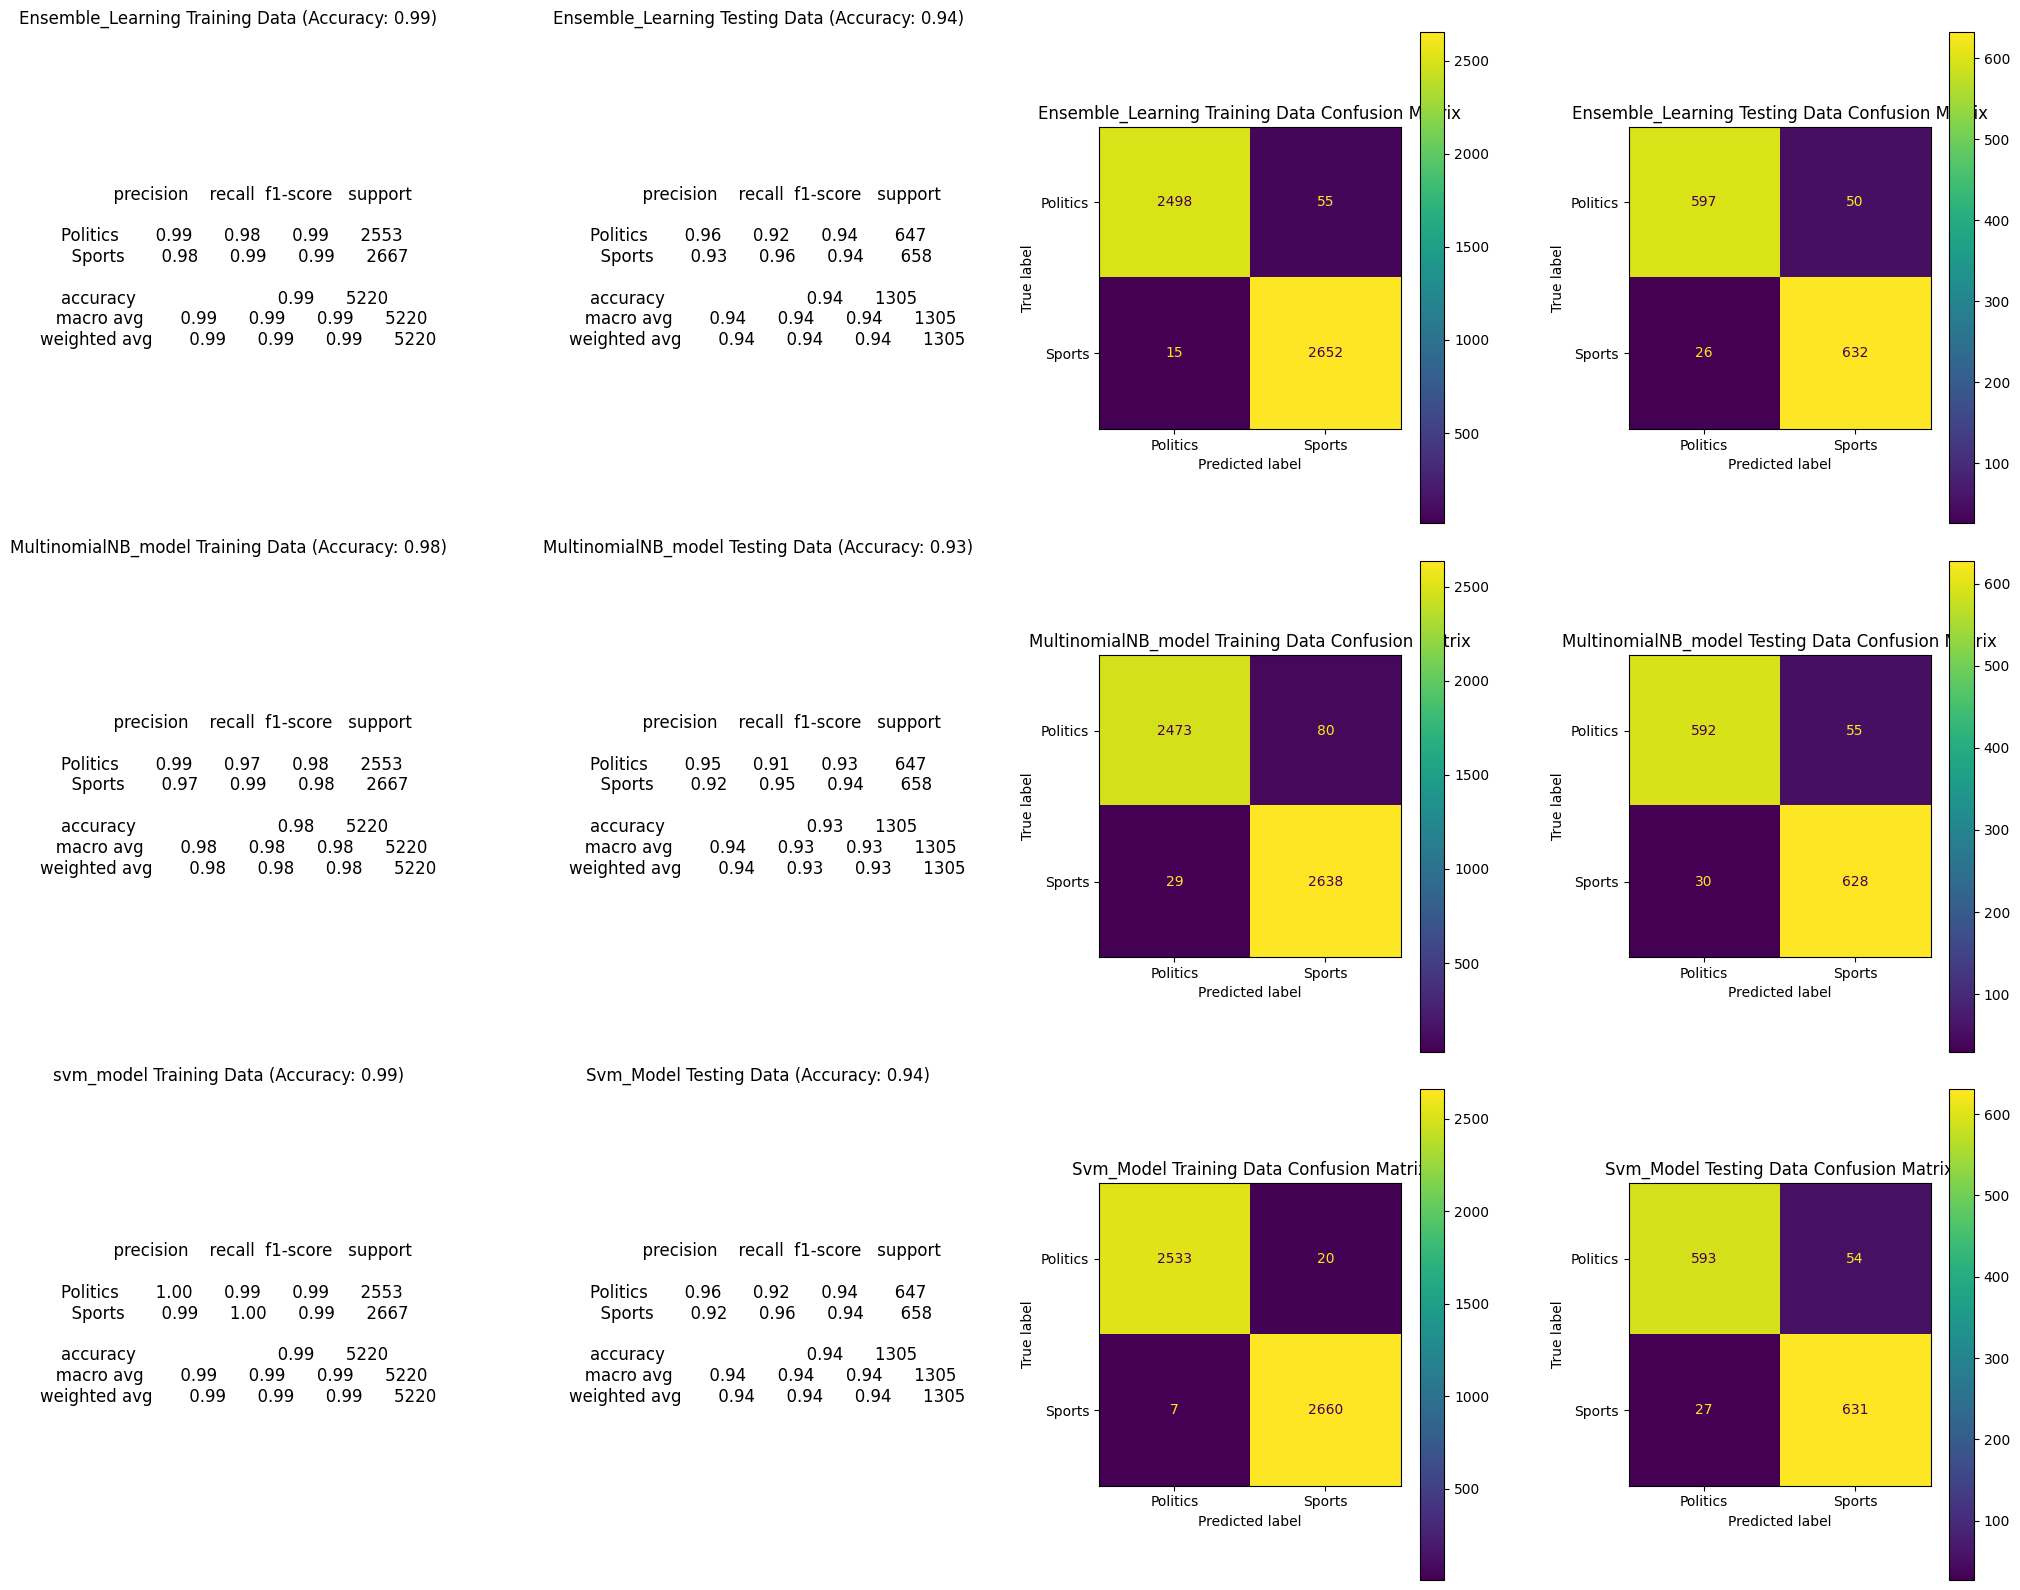

In [65]:
# Predictions for training data - Model 1
y_train_predict1 = ensemble_model.predict(X_train1)

# Predictions for testing data - Model 1
y_test_predict1 = ensemble_model.predict(X_test1)

# Predictions for training data - Model 2
y_train_predict2 = MultinomialNB_model.predict(X_train1)

# Predictions for testing data - Model 2
y_test_predict2 = MultinomialNB_model.predict(X_test1)

# Predictions for training data - Model 3
y_train_predict3 = svm_model.predict(X_train1)

# Predictions for testing data - Model 3
y_test_predict3 = svm_model.predict(X_test1)

# Classification report for training data - Model 1
train_report_str1 = classification_report(y_train1, y_train_predict1)
train_report1 = classification_report(y_train1, y_train_predict1, output_dict=True)

# Classification report for testing data - Model 1
test_report_str1 = classification_report(y_test1, y_test_predict1)
test_report1 = classification_report(y_test1, y_test_predict1, output_dict=True)

# Classification report for training data - Model 2
train_report_str2 = classification_report(y_train1, y_train_predict2)
train_report2 = classification_report(y_train1, y_train_predict2, output_dict=True)

# Classification report for testing data - Model 2
test_report_str2 = classification_report(y_test1, y_test_predict2)
test_report2 = classification_report(y_test1, y_test_predict2, output_dict=True)

# Classification report for training data - Model 3
train_report_str3 = classification_report(y_train1, y_train_predict3)
train_report3 = classification_report(y_train1, y_train_predict3, output_dict=True)

# Classification report for testing data - Model 3
test_report_str3 = classification_report(y_test1, y_test_predict3)
test_report3 = classification_report(y_test1, y_test_predict3, output_dict=True)

# Confusion matrix for training data - Model 1
train_conf_matrix1 = confusion_matrix(y_train1, y_train_predict1)

# Confusion matrix for testing data - Model 1
test_conf_matrix1 = confusion_matrix(y_test1, y_test_predict1)

# Confusion matrix for training data - Model 2
train_conf_matrix2 = confusion_matrix(y_train1, y_train_predict2)

# Confusion matrix for testing data - Model 2
test_conf_matrix2 = confusion_matrix(y_test1, y_test_predict2)

# Confusion matrix for training data - Model 3
train_conf_matrix3 = confusion_matrix(y_train1, y_train_predict3)

# Confusion matrix for testing data - Model 3
test_conf_matrix3 = confusion_matrix(y_test1, y_test_predict3)

# Function to extract accuracy from classification report string
def extract_accuracy(report_str):
    accuracy_str = re.findall(r'accuracy\s*([\d.]+)', report_str)
    if accuracy_str:
        return float(accuracy_str[0])
    else:
        return None

# Extract accuracy for training and testing data - Model 1
accuracy_train1 = extract_accuracy(train_report_str1)
accuracy_test1 = extract_accuracy(test_report_str1)

# Extract accuracy for training and testing data - Model 2
accuracy_train2 = extract_accuracy(train_report_str2)
accuracy_test2 = extract_accuracy(test_report_str2)

# Extract accuracy for training and testing data - Model 3
accuracy_train3 = extract_accuracy(train_report_str3)
accuracy_test3 = extract_accuracy(test_report_str3)

# Create subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 16))

# Plot classification report for training data - Model 1
axes[0, 0].text(0, 0.5, train_report_str1, fontsize=12, verticalalignment='center')
axes[0, 0].axis('off')
axes[0, 0].set_title(f'Ensemble_Learning Training Data (Accuracy: {accuracy_train1:.2f})')

# Plot classification report for testing data - Model 1
axes[0, 1].text(0, 0.5, test_report_str1, fontsize=12, verticalalignment='center')
axes[0, 1].axis('off')
axes[0, 1].set_title(f'Ensemble_Learning Testing Data (Accuracy: {accuracy_test1:.2f})')

# Plot confusion matrix for training data - Model 1
ConfusionMatrixDisplay(
    train_conf_matrix1,
    display_labels=["Politics", "Sports"], 
).plot(ax=axes[0, 2])
axes[0, 2].set_title('Ensemble_Learning Training Data Confusion Matrix')

# Plot confusion matrix for testing data - Model 1
ConfusionMatrixDisplay(
    test_conf_matrix1,
    display_labels=["Politics", "Sports"], 
).plot(ax=axes[0, 3])
axes[0, 3].set_title('Ensemble_Learning Testing Data Confusion Matrix')

# Plot classification report for training data - Model 2
axes[1, 0].text(0, 0.5, train_report_str2, fontsize=12, verticalalignment='center')
axes[1, 0].axis('off')
axes[1, 0].set_title(f'MultinomialNB_model Training Data (Accuracy: {accuracy_train2:.2f})')

# Plot classification report for testing data - Model 2
axes[1, 1].text(0, 0.5, test_report_str2, fontsize=12, verticalalignment='center')
axes[1, 1].axis('off')
axes[1, 1].set_title(f'MultinomialNB_model Testing Data (Accuracy: {accuracy_test2:.2f})')

# Plot confusion matrix for training data - Model 2
ConfusionMatrixDisplay(
    train_conf_matrix2,
    display_labels=["Politics", "Sports"], 
).plot(ax=axes[1, 2])
axes[1, 2].set_title('MultinomialNB_model Training Data Confusion Matrix')

# Plot confusion matrix for testing data - Model 2
ConfusionMatrixDisplay(
    test_conf_matrix2,
    display_labels=["Politics", "Sports"], 
).plot(ax=axes[1, 3])
axes[1, 3].set_title('MultinomialNB_model Testing Data Confusion Matrix')

# Plot classification report for training data - Model 3
axes[2, 0].text(0, 0.5, train_report_str3, fontsize=12, verticalalignment='center')
axes[2, 0].axis('off')
axes[2, 0].set_title(f'svm_model Training Data (Accuracy: {accuracy_train3:.2f})')

# Plot classification report for testing data - Model 3
axes[2, 1].text(0, 0.5, test_report_str3, fontsize=12, verticalalignment='center')
axes[2, 1].axis('off')
axes[2, 1].set_title(f'Svm_Model Testing Data (Accuracy: {accuracy_test3:.2f})')

# Plot confusion matrix for training data - Model 3
ConfusionMatrixDisplay(
    train_conf_matrix3,
    display_labels=["Politics", "Sports"], 
).plot(ax=axes[2, 2])
axes[2, 2].set_title('Svm_Model Training Data Confusion Matrix')

# Plot confusion matrix for testing data - Model 3
ConfusionMatrixDisplay(
    test_conf_matrix3,
    display_labels=["Politics", "Sports"], 
).plot(ax=axes[2, 3])
axes[2, 3].set_title('Svm_Model Testing Data Confusion Matrix')

plt.tight_layout()
plt.show()


### Model Selection Justification
##### After thorough experimentation and evaluation, Multinomial Naive Bayes (MNB) was chosen as the preferred model. The decision was based on several factors, including its computational efficiency, ability to handle large datasets, and resistance to overfitting. These characteristics make MNB a suitable choice for the task at hand, ensuring both speed and reliability in classification tasks.


In [ ]:
MultinomialNB_model = MultinomialNB(alpha=2)
MultinomialNB_model.fit(X_train2, y_train2)

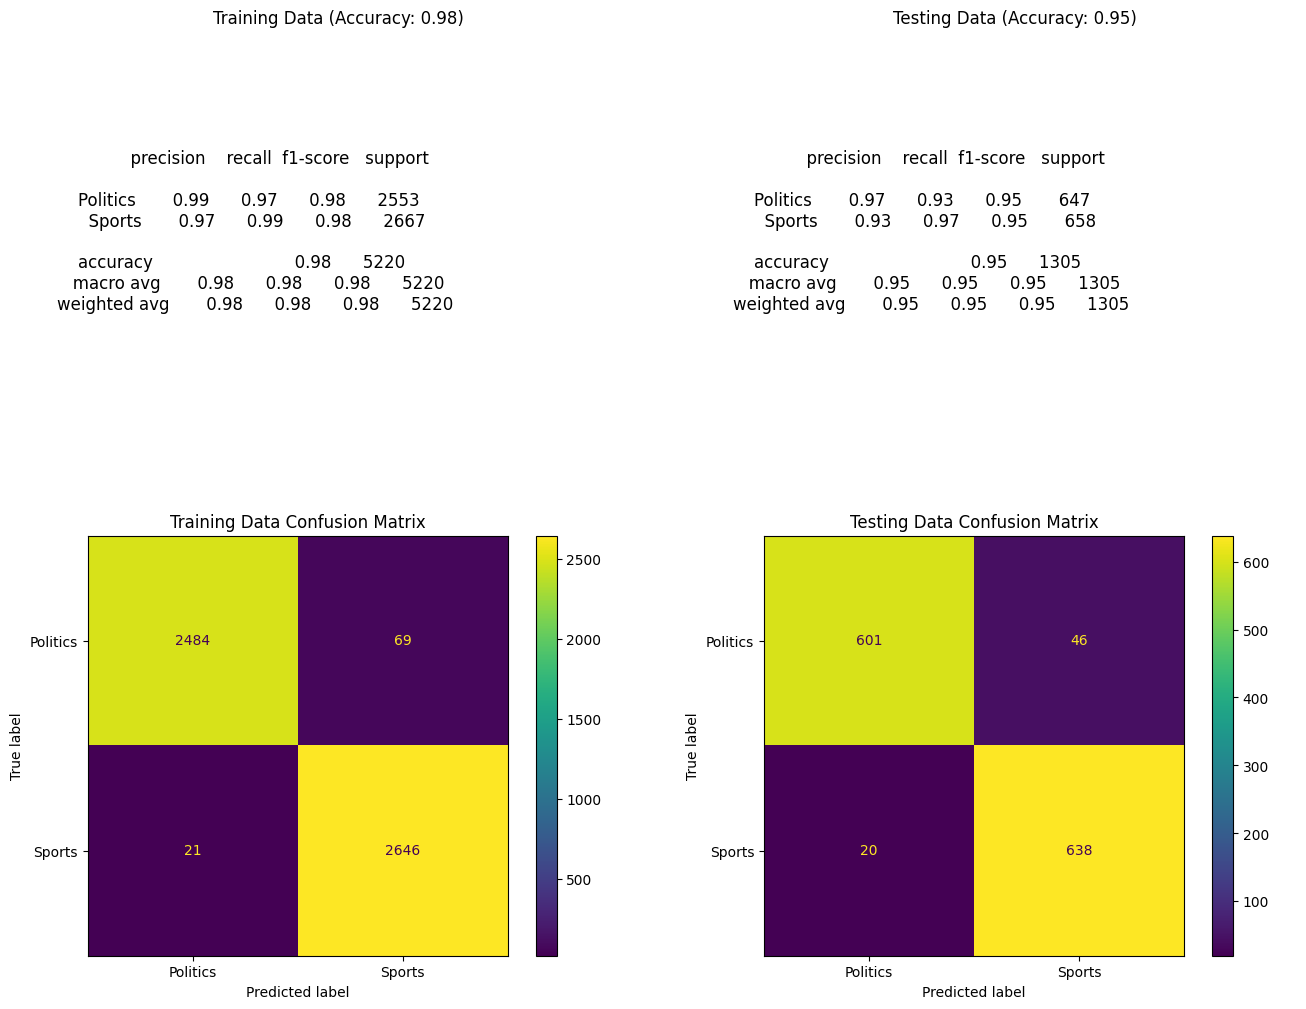

In [11]:
# Predictions for training data
y_train_predict = MultinomialNB_model.predict(X_train2)

# Predictions for testing data
y_test_predict = MultinomialNB_model.predict(X_test2)

# Classification report for training data
train_report_str = classification_report(y_train2, y_train_predict)
train_report = classification_report(y_train2, y_train_predict, output_dict=True)

# Classification report for testing data
test_report_str = classification_report(y_test2, y_test_predict)
test_report = classification_report(y_test2, y_test_predict, output_dict=True)

# Confusion matrix for training data
train_conf_matrix = confusion_matrix(y_train2, y_train_predict)

# Confusion matrix for testing data
test_conf_matrix = confusion_matrix(y_test2, y_test_predict)

# Function to extract accuracy from classification report string
def extract_accuracy(report_str):
    accuracy_str = re.findall(r'accuracy\s*([\d.]+)', report_str)
    if accuracy_str:
        return float(accuracy_str[0])
    else:
        return None

# Extract accuracy for training and testing data
accuracy_train = extract_accuracy(train_report_str)
accuracy_test = extract_accuracy(test_report_str)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot classification report for training data
axes[0, 0].text(0, 0.5, train_report_str, fontsize=12, verticalalignment='center')
axes[0, 0].axis('off')
axes[0, 0].set_title(f'Training Data (Accuracy: {accuracy_train:.2f})')

# Plot classification report for testing data
axes[0, 1].text(0, 0.5, test_report_str, fontsize=12, verticalalignment='center')
axes[0, 1].axis('off')
axes[0, 1].set_title(f'Testing Data (Accuracy: {accuracy_test:.2f})')

# Plot confusion matrix for training data
ConfusionMatrixDisplay(
    train_conf_matrix,
    display_labels=["Politics", "Sports"], 
).plot(ax=axes[1, 0])
axes[1, 0].set_title('Training Data Confusion Matrix')

# Plot confusion matrix for testing data
ConfusionMatrixDisplay(
    test_conf_matrix,
    display_labels=["Politics", "Sports"], 
).plot(ax=axes[1, 1])
axes[1, 1].set_title('Testing Data Confusion Matrix')

plt.show()

# Submission

#### Using Trained Multinomial Naive Bayes (MNB) Model to Classify Tweets

The provided code segment demonstrates the creation of a submission file for tweet classification using a trained Multinomial Naive Bayes (MNB) model. The process involves several key steps:

1. **Data Preprocessing**:
   - The 'TweetText' column in the test dataset is preprocessed using the `clean_text` function to clean the text data by converting it to lowercase, removing numbers, HTML tags, URLs, emojis, and punctuations.
   
   
2. **Feature Extraction**:
   - The TfidfVectorizer is employed to transform the cleaned tweet text into numerical feature vectors.
   
   
3. **Model Training**:
   - The Multinomial Naive Bayes (MNB) model is trained using the feature vectors derived from the training dataset.
   
   
4. **Prediction**:
   - The trained MNB model is utilized to predict the labels (i.e., 'Politics' or 'Sports') for the tweet texts in the test dataset.
   
   
5. **Submission File Creation**:
   - A submission DataFrame is created with 'TweetId' and predicted 'Label' columns.
   - The submission DataFrame is exported to a CSV file named 'final_submission.csv' without including the index.

By following these steps, the code effectively generates a submission file ('final_submission.csv') that contains the predicted labels for the tweets in the test dataset, allowing for evaluation and submission in the respective tweet classification competition or task.

In [ ]:
test_data

#### Data Cleaning and Feature Extraction and Model Training Using MultinomialNB which is the best model voted in the ensemble_model

In [12]:
test_data['TweetClean'] = test_data['TweetText'].apply(clean_text)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['TweetClean']).toarray()
X_test = vectorizer.transform(test_data['TweetClean']).toarray()

# Train the model
model = MultinomialNB(alpha=2)
model.fit(X_train, y)

MultinomialNB(alpha=2)

In [13]:
test_pred = model.predict(X_test)

# create submission file
submission = pd.DataFrame({'TweetId': test_data['TweetId'], 'Label': test_pred})
submission.to_csv('final_submission.csv', index=False)

In [14]:
submission

,TweetId,Label
0,306486520121012224,Sports
1,286353402605228032,Sports
2,289531046037438464,Politics
3,306451661403062273,Politics
4,297941800658812928,Sports
...,...,...
2605,282023761044189184,Sports
2606,303879735006601216,Sports
2607,297956846046703616,Sports
2608,304265049537658880,Politics
